In [1]:
!pip install torchtext==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━

In [2]:
import torchtext
import torch
import torch.nn as nn
from torch.nn import functional as F

In [3]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [4]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.1, device = 'cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            src_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                )
                for i in range(num_layers)
            ]
        )

    def forward(self, x):
      output = self.embedding(x)
      for layer in self.layers:
        output = layer(output, output, output)
      return output

In [6]:
class TransformerDecoderBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
    super().__init__()
    self.attn = nn.MultiheadAttention(
        embed_dim=embed_dim,
        num_heads=num_heads,
        batch_first=True
    )
    self.cross_attn = nn.MultiheadAttention(
        embed_dim=embed_dim,
        num_heads=num_heads,
        batch_first=True
    )
    self.ffn = nn.Sequential(
        nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
    )
    self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
    self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
    self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
    self.dropout_1 = nn.Dropout(p=dropout)
    self.dropout_2 = nn.Dropout(p=dropout)
    self.dropout_3 = nn.Dropout(p=dropout)
  def forward(self, x, enc_output, src_mask, tgt_mask):
    attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
    attn_output = self.dropout_1(attn_output)
    out_1 = self.layernorm_1(x + attn_output)

    attn_output, _ = self.cross_attn(
        out_1, enc_output, enc_output, attn_mask=src_mask)
    attn_output = self.dropout_2(attn_output)
    out_2 = self.layernorm_2(out_1 + attn_output)

    ffn_output = self.ffn(out_2)
    ffn_output = self.dropout_3(ffn_output)
    out_3 = self.layernorm_3(out_2 + ffn_output)
    return out_3

In [7]:
class TransformerDecoder(nn.Module):
  def __init__(self,
               tgt_vocal_size,
               embed_dim, max_length, num_layers, num_heads, ff_dim,
               dropout=0.1, device = 'cpu'):
    super().__init__()
    self.embedding = TokenAndPositionEmbedding(
        tgt_vocal_size, embed_dim, max_length, device
    )
    self.layers = nn.ModuleList(
        [
            TransformerEncoderBlock(
                embed_dim, num_heads, ff_dim, dropout
            )
            for i in range(num_layers)
        ]
    )

  def foward(self, x, enc_output, src_mask, tgt_mask):
    output = self.embedding(x)
    for layer in self.layers:
      output = layer(output, enc_output, src_mask, tgt_mask)
    return output

In [8]:
class Transformer(nn.Module):
  def __init__(self,
               src_vocal_size,
               tgt_vocal_size,
               embed_dim, max_length, num_layers, num_heads, ff_dim,
               dropout=0.1, device = 'cpu'):
    super().__init__()
    self.device = device
    self.encoder = TransformerEncoder(
        src_vocal_size, embed_dim, max_length, num_layers,
        num_heads, ff_dim
    )
    self.decoder = TransformerDecoder(
        tgt_vocal_size, embed_dim, max_length, num_layers,
        num_heads, ff_dim
    )
    self.fc = nn.Linear(embed_dim, tgt_vocab_size)

  def generate_mask(self, src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device = self.device).type(torch.bool)

    tgt_mask = (torch.tril(torch.ones((tgt_seq_len, tgt_seq_len),
                                     device = self.device)) == 1).transpose(0, 1)
    tgt_mask = tgt_mask.float().masked_fill(
        tgt_mask == 0, float('-inf').masked_fill(tgt_mask == 1), float(0.0))
    return src_mask, tgt_mask

  def forward(self, src, tgt):
    src_mask, tgt_mask = self.generate_mask(src, tgt)
    enc_output = self.encoder(src)
    dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
    output = self.fc(dec_output)
    return output

In [9]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [10]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [11]:
!pip install datasets

In [12]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

README.md:   0%|          | 0.00/570 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

In [14]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [15]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [16]:
# word-based tokenizer
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [17]:
ds['train']['preprocessed_sentence'][0]

'cửa hàng nhỏ xinh trên mặt đường vị trí khá dễ tìm đồ ăn ngon giá phải chăng bánh mỳ chảo cười bánh mỳ sốt vang và xúc xích cùng sữa ngô nữa hết có k qúa ổn luôn'

In [18]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [19]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)

In [20]:
for row in ds['train']:
    print(vocabulary(tokenizer(row['preprocessed_sentence'])))
    break

[351, 111, 112, 529, 124, 228, 196, 53, 159, 43, 103, 256, 46, 2, 11, 31, 52, 723, 32, 491, 991, 533, 32, 491, 220, 1415, 9, 731, 897, 185, 130, 836, 57, 88, 4, 14, 3183, 251, 59]


In [21]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [22]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [23]:
next(iter(train_dataloader))

(tensor([[  86,  244,   17,  ...,    0,    0,    0],
         [   7,   28,  230,  ...,    0,    0,    0],
         [   6,  995,   12,  ...,  331,   35,   33],
         ...,
         [ 211,   39,  102,  ...,  106, 1325,   18],
         [  22,  336,   96,  ...,    0,    0,    0],
         [ 109,  494,  288,  ...,   40,   10,  449]]),
 tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
         1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         1, 1, 1, 0, 0, 0, 0, 0]))

In [24]:
len(train_dataloader)

235

In [25]:
encoded_sentences, labels = next(iter(train_dataloader))
encoded_sentences.shape

torch.Size([128, 100])

In [26]:
labels.shape

torch.Size([128])

In [36]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [37]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [38]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [39]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [31]:
class TransformerEncoderCls(nn.Module):
  def __init__(self,
               vocal_size,
               max_length, num_layers, embed_dim, num_heads, ff_dim,
               dropout=0.1, device = 'cpu'):
    super().__init__()
    self.encoder = TransformerEncoder(
        vocab_size, embed_dim, max_length, num_layers,
        num_heads, ff_dim, dropout, device
    )

    self.pooling = nn.AvgPool1d(kernel_size=max_length)
    self.fc1 = nn.Linear(in_features=embed_dim, out_features = 20)
    self.fc2 = nn.Linear(in_features=20, out_features = 2)
    self.dropout = nn.Dropout(p=dropout)
    self.relu = nn.ReLU()

  def forward(self, x):
    output = self.encoder(x)
    output = self.pooling(output.permute(0, 2, 1)).squeeze()
    output = self.dropout(output)
    output = self.fc1(output)
    output = self.dropout(output)
    output = self.fc2(output)
    return output

In [32]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

In [33]:
encoded_sentences.shape

torch.Size([128, 100])

In [34]:
predictions = model(encoded_sentences)

In [35]:
predictions.shape

torch.Size([128, 2])

In [36]:
predictions

tensor([[-1.5040e-01, -1.8218e-01],
        [ 6.6125e-02, -1.9405e-01],
        [ 1.2459e-01, -2.9481e-01],
        [-4.0308e-03, -3.3804e-01],
        [ 9.6702e-02, -3.3638e-01],
        [ 4.5892e-02, -2.6890e-01],
        [ 6.9628e-02, -4.5116e-01],
        [ 3.7309e-02, -3.3064e-01],
        [ 1.8148e-01, -3.4200e-01],
        [ 8.7166e-03, -3.1074e-01],
        [-6.0633e-02, -2.9948e-01],
        [ 1.8757e-01, -4.5643e-01],
        [-4.8272e-04, -1.9266e-01],
        [-7.3140e-02, -1.5059e-01],
        [ 4.3587e-02, -3.4505e-01],
        [ 1.5007e-01, -3.9706e-01],
        [ 7.9562e-03, -3.4039e-01],
        [-3.2004e-02, -1.8129e-01],
        [-8.3759e-03, -2.7894e-01],
        [-1.4903e-01, -1.8577e-01],
        [-5.4301e-02, -2.6716e-01],
        [ 9.3047e-03, -2.7271e-01],
        [ 3.7101e-01, -2.9034e-01],
        [ 1.9472e-01, -3.0120e-01],
        [ 1.8220e-01, -4.7234e-01],
        [-6.5195e-02, -2.2506e-01],
        [ 7.1306e-02, -1.5591e-01],
        [-1.0916e-02, -1.587

In [37]:
import os
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

| epoch   1 |    50/  235 batches | accuracy    0.512
| epoch   1 |   100/  235 batches | accuracy    0.575
| epoch   1 |   150/  235 batches | accuracy    0.664
| epoch   1 |   200/  235 batches | accuracy    0.716
-----------------------------------------------------------
| End of epoch   1 | Time:  7.37s | Train Accuracy    0.749 | Train Loss    0.645 | Valid Accuracy    0.755 | Valid Loss    0.526 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.765
| epoch   2 |   100/  235 batches | accuracy    0.781
| epoch   2 |   150/  235 batches | accuracy    0.791
| epoch   2 |   200/  235 batches | accuracy    0.795
-----------------------------------------------------------
| End of epoch   2 | Time:  7.00s | Train Accuracy    0.803 | Train Loss    0.469 | Valid Accuracy    0.791 | Valid Loss    0.454 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.807
| epoch   3 

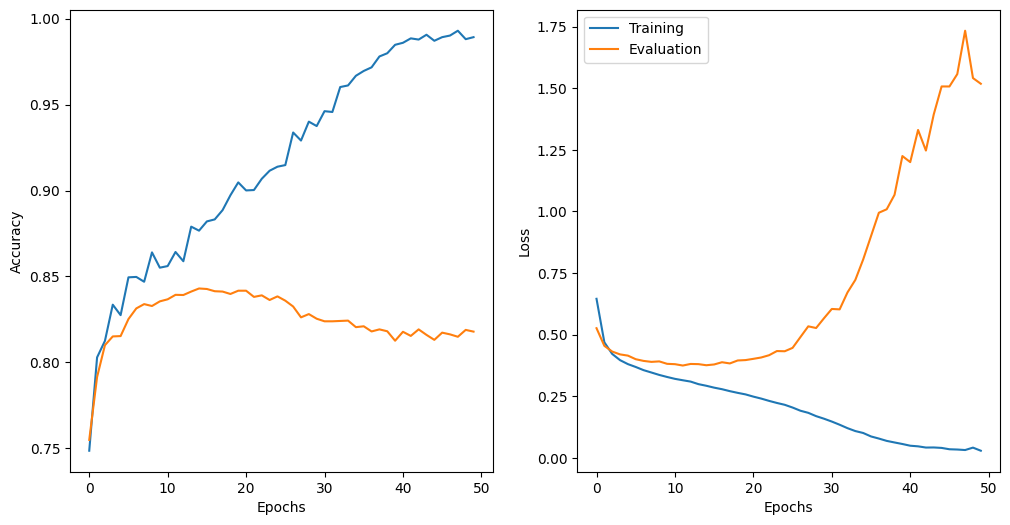

In [38]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [39]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8222, 1.4209960472734668)

Text Classification using BERT

In [9]:
!pip install -q datasets accelerate evaluate

In [10]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

In [12]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

In [13]:
tokenizer.model_max_length

512

In [14]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts

    result = tokenizer(
        examples["preprocessed_sentence"],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result["label"] = examples['label']

    return result

In [15]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = ds.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [16]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.4 MB/s eta 0:00:000:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━

In [17]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task='text-classification'
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [19]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

In [20]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='ntc-scv-distilbert-base-uncased',
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import wandb
wandb.init(mode='disabled')

In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.524382,0.749300
2,No log,0.456736,0.787900
3,No log,0.446437,0.798400
4,No log,0.415170,0.815300
5,No log,0.410246,0.818100
6,No log,0.408367,0.823900
7,No log,0.401963,0.826100
8,No log,0.393525,0.829500
9,0.422900,0.394125,0.830900
10,0.422900,0.396808,0.831100


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=590, training_loss=0.4089251987004684, metrics={'train_runtime': 1561.8746, 'train_samples_per_second': 192.077, 'train_steps_per_second': 0.378, 'total_flos': 7761761640000000.0, 'train_loss': 0.4089251987004684, 'epoch': 10.0})

In [23]:
trainer.evaluate(processed_dataset["test"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.37132728099823,
 'eval_accuracy': 0.8438,
 'eval_runtime': 17.2541,
 'eval_samples_per_second': 579.572,
 'eval_steps_per_second': 1.159,
 'epoch': 10.0}

In [24]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="thainq107/ntc-scv-distilbert-base-uncased"
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [25]:
classifier("quán ăn này ngon quá luôn nè")

[{'label': 'LABEL_1', 'score': 0.7825171947479248}]

## **Vision Transformer**

In [26]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch import nn
import math
import os

In [27]:
! gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=75179fb5-06ab-4ef7-a8a0-f8c27510a420
To: /kaggle/working/flower_photos.zip
100%|█████████████████████████████████████████| 230M/230M [00:01<00:00, 142MB/s]


In [28]:
!unzip ./flower_photos.zip

Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/

In [41]:
data_patch = '/kaggle/working/flower_photos'
dataset = ImageFolder(data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

train_ratio, val_ratio = 0.8, 0.1
n_train_examples = int(num_samples * train_ratio)
n_val_examples = int(num_samples * val_ratio)
n_test_examples = num_samples - n_train_examples - n_val_examples

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_val_examples, n_test_examples]
)

In [42]:
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms
val_dataset.dataset.transform = test_transforms

In [43]:
batch_size = 512

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

valid_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size
)

In [44]:
class PatchPositionEmbedding(nn.Module):
  def __init__(self, image_size = 224, embed_dim = 512, patch_size = 16,
               device = 'cpu'):
    super().__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = embed_dim,
        kernel_size = patch_size,
        stride = patch_size,
        bias = False
    )
    scale = embed_dim ** -0.5
    self.position_embedding = nn.Parameter(
        scale * torch.randn((image_size // patch_size)**2, embed_dim))
    self.device = device

  def forward(self, x):
    x = self.conv1(x)
    x = x.reshape(x.shape[0], x.shape[1], -1)
    x = x.permute(0, 2, 1)
    x = x + self.position_embedding.to(self.device)
    return x

In [45]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 embed_dim, num_heads, ff_dim,
                 dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
          embed_dim = embed_dim,
          num_heads = num_heads,
          batch_first = True
        )
        self.fnn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim, bias = True),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim, bias = True)
        )
        self.layernorm_1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.fnn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [46]:
class VisionTransformerCls(nn.Module):
  def __init__(self,
               image_size, embed_dim, num_heads, ff_dim, dropout = 0.1,
               device = 'cpu', num_classes = 10, patch_size = 16
               ):
    super().__init__()
    self.embd_layer = PatchPositionEmbedding(
        image_size = image_size, embed_dim = embed_dim,
        patch_size = patch_size, device = device
    )
    self.transformer_layer = TransformerEncoder(
        embed_dim, num_heads, ff_dim, dropout)
    self.fc1 = nn.Linear(in_features=embed_dim, out_features = 20)
    self.fc2 = nn.Linear(in_features=20, out_features = num_classes)
    self.dropout = nn.Dropout(p=dropout)
    self.relu = nn.ReLU()

  def forward(self,x):
    output = self.embd_layer(x)
    output = self.transformer_layer(output, output, output)
    output = output[:, 0, :]
    output = self.dropout(output)
    output = self.fc1(output)
    output = self.dropout(output)
    output = self.fc2(output)
    return output

In [47]:
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size, embed_dim, num_heads, ff_dim, dropout, device=device, num_classes=num_classes #Pass num_classes as a keyword argument
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok = True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 14.71s | Train Accuracy    0.266 | Train Loss    1.617 | Valid Accuracy    0.297 | Valid Loss    1.589 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 14.61s | Train Accuracy    0.328 | Train Loss    1.527 | Valid Accuracy    0.346 | Valid Loss    1.522 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 15.09s | Train Accuracy    0.361 | Train Loss    1.482 | Valid Accuracy    0.343 | Valid Loss    1.484 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 14.34s | Train Accuracy    0.364 | Train Loss    1.442 | Valid Accuracy    0.387 | Valid Loss    1.453 
--------------------------------------------------------

In [48]:
from transformers import ViTForImageClassification

id2label = {id : label for id, label in enumerate(classes)}
label2id = {label : id for id, label in id2label.items()}

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                     num_labels = num_classes,
                                                     id2label = id2label,
                                                     label2id = label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [52]:
!pip install -q datasets accelerate evaluate

In [53]:
import evaluate
import numpy as np

metric = evaluate . load (" accuracy ")

def compute_metric(eval_pred):
    predictions, labels = eval_pred
    predctions = np.argmax(predictions, axis = 1)
    return metric.compute(predictions=predictions,
                            refrences = labels)

FileNotFoundError: Couldn't find a module script at /kaggle/working/ accuracy / accuracy .py. Module ' accuracy ' doesn't exist on the Hugging Face Hub either.

In [56]:
import torch
from transformers import ViTImageProcessor, TrainingArguments, TrainerViTImageProcessorViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained(" google/vit-base-patch16-224-in21k")

metric_name = "accuracy"

args = TrainingArguments(
    f" vit_flowers ",
    save_strategy =" epoch ",
    evaluation_strategy =" epoch ",
    learning_rate =2e-5 ,
    per_device_train_batch_size =32 ,
    per_device_eval_batch_size =32 ,
    num_train_epochs =10 ,
    weight_decay =0.01 ,
    load_best_model_at_end = True ,
    metric_for_best_model = metric_name ,
    logging_dir ='logs',
    remove_unused_columns = False ,
)

def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values , " labels ": labels }

ImportError: cannot import name 'TrainerViTImageProcessorViTImageProcessor' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset = valid_dataset,
    data_collator=collate_fn,
    compute_metrics = compute_metrics,
    tokenize = feature_extractor,
)

In [ ]:
trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metric